In [1]:
!git clone https://github.com/ClementPinard/FlowNetPytorch.git

Cloning into 'FlowNetPytorch'...
remote: Enumerating objects: 529, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 529 (delta 7), reused 13 (delta 7), pack-reused 512
Receiving objects: 100% (529/529), 1.21 MiB | 23.88 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [ ]:
!pip install -r /content/FlowNetPytorch/requirements.txt

In [5]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!python3 /content/FlowNetPytorch/run_inference.py /content/drive/MyDrive/ISLAB/EXP3/D1 /content/drive/MyDrive/ISLAB/EXP5/FlowNetModels/pytorch/flownets_EPE1.951.pth

In [ ]:
!python3 /content/FlowNetPytorch/run_inference.py /content/drive/MyDrive/ISLAB/EXP3/D2 /content/drive/MyDrive/ISLAB/EXP5/FlowNetModels/pytorch/flownets_EPE1.951.pth

In [7]:
!python3 /content/FlowNetPytorch/run_inference.py /content/drive/MyDrive/ISLAB/EXP3/D3 /content/drive/MyDrive/ISLAB/EXP5/FlowNetModels/pytorch/flownets_EPE1.951.pth

=> will save raw output and RGB visualization
=> fetching img pairs in '/content/drive/MyDrive/ISLAB/EXP3/D3'
=> will save everything to /content/drive/MyDrive/ISLAB/EXP3/D3/flow
1 samples found
=> using pre-trained model 'flownets'
  0% 0/1 [00:00<?, ?it/s]/content/FlowNetPytorch/run_inference.py:91: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = input_transform(imread(img1_file))
/content/FlowNetPytorch/run_inference.py:92: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = input_transform(imread(img2_file))
100% 1/1 [00:04<00:00,  4.44s/it]


##Lucas Kanade Algorithm

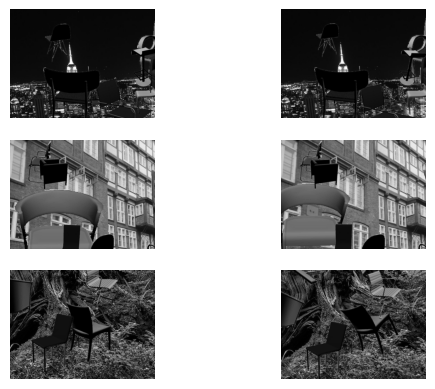

In [8]:
D = []
img_paths = []
lst = []
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D1/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D1/img2.jpg"])
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D2/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D2/img2.jpg"])
img_paths.append(["/content/drive/MyDrive/ISLAB/EXP3/D3/img1.jpg","/content/drive/MyDrive/ISLAB/EXP3/D3/img2.jpg"])
grayscale_transform = transforms.Grayscale()
def normalize_image(image):
    return image.astype(np.float32) / 255.0

for i in range(10):
  for j in range(2):
    image = Image.open(img_paths[i][j])
    gray_image = image.convert("L")
    gray_img = (np.array(gray_image,dtype=np.int32))
    lst.append(gray_img)

  D.append(lst)
  lst = []

fig, axs = plt.subplots(10, 2)
for i in range(10):
    for j in range(2):
        axs[i, j].imshow(D[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

In [9]:
import numpy as np

def compute_gradients(image1, image2):

  Ix = np.zeros((image1.shape[0]-1, image1.shape[1]-1))
  Iy = np.zeros((image1.shape[0]-1, image1.shape[1]-1))
  It = np.zeros((image1.shape[0]-1, image1.shape[1]-1))

  for k in range(image1.shape[0]-1):
    for l in range(image1.shape[1]-1):
        Ix[k, l] = image1[k+1, l] + image2[k+1, l] + image1[k+1, l+1] + image2[k+1, l+1] - (image1[k, l] + image2[k, l] + image1[k, l+1] + image2[k, l+1])
        Ix[k, l] /= 4.0

        Iy[k, l] = image1[k, l+1] + image2[k, l+1] + image1[k+1, l+1] + image2[k+1, l+1] - (image1[k, l] + image2[k, l] + image1[k+1, l] + image2[k+1, l])
        Iy[k, l] /= 4.0

        It[k, l] = image1[k, l] + image1[k+1, l] + image1[k, l+1] + image1[k+1, l+1] - (image2[k, l] + image2[k, l+1] + image2[k+1, l] + image2[k+1, l+1])
        It[k, l] /= 4.0

  return Ix, Iy, It

In [10]:
def lucas_kanade_optical_flow(Ix, Iy, It, window_size):
    half_window = window_size // 2
    u = np.zeros_like(Ix)
    v = np.zeros_like(Ix)

    for i in range(half_window, Ix.shape[0] - half_window):
        for j in range(half_window, Ix.shape[1] - half_window):

            Ix_window = (np.transpose(Ix[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1])).flatten()
            Iy_window = (np.transpose(Iy[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1])).flatten()
            It_window = (np.transpose(It[i - half_window : i + half_window + 1, j - half_window : j + half_window + 1])).flatten()

            A = np.vstack((Ix_window, Iy_window)).T
            b = -It_window.reshape((-1, 1))

            if np.linalg.matrix_rank(A) == 2:

                ATA_inv = np.linalg.inv(np.dot(A.T, A))
                flow = np.dot(np.dot(ATA_inv, A.T), b)
                u[i, j] = flow.item(0)
                v[i, j] = flow.item(1)

    return u, v


In [11]:
Ix_list = []
Iy_list = []
It_list = []
for i in range(10):
  Ix,Iy,It = compute_gradients(D[i][0],D[i][1])
  Ix_list.append(Ix)
  Iy_list.append(Iy)
  It_list.append(It)

In [13]:
gt1 = "/content/drive/MyDrive/ISLAB/EXP3/D1/GT1.npy"
gt2 = "/content/drive/MyDrive/ISLAB/EXP3/D2/GT2.npy"
gt3 = "/content/drive/MyDrive/ISLAB/EXP3/D3/GT3.npy"

gt_paths = [gt1,gt2,gt3]
gts = []

for i in range(3):
  data = np.load(gt_paths[i])
  gts.append(data)

(96, 128, 2)
(96, 128)
(384, 512)
(384, 512)


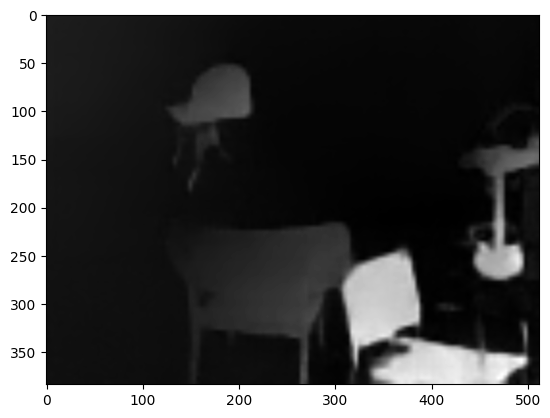

In [23]:
import cv2

ndat = np.load("/content/drive/MyDrive/ISLAB/EXP3/D1/flow/imgflow.npy")
print(ndat.shape)
mag = np.sqrt(np.sum(ndat ** 2, axis=2))
print(mag.shape)
# Upsample the magnitude
ups = cv2.resize(mag, (4*mag.shape[1], 4*mag.shape[0]), interpolation=cv2.INTER_LINEAR)

print(gts[0].shape)
print(ups.shape)

plt.imshow(ups, cmap='gray')

In [5]:
import numpy as np

def read_flo_file(filename):
    """
    Read from Middlebury .flo file
    :param flow_file: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)[0]
    data2d = None

    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
    else:
        w = np.fromfile(f, np.int32, count=1)[0]
        h = np.fromfile(f, np.int32, count=1)[0]
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d


In [25]:
window_sizes = [3,5, 15]
u_list =[]
v_list = []
res_list =[]

for i in range(10):
  print(f"For image_{i}:")
  u, v = lucas_kanade_optical_flow(Ix_list[i], Iy_list[i], It_list[i], 3)

  ndat = np.load(f"/content/drive/MyDrive/ISLAB/EXP3/D{i+1}/flow/imgflow.npy")
  mag = np.sqrt(np.sum(ndat ** 2, axis=2))
  ups = cv2.resize(mag, (4*mag.shape[1], 4*mag.shape[0]), interpolation=cv2.INTER_LINEAR)

  res = np.sqrt(u**2 + v**2)
  res_list.append(res)
  if i>3:
    tmp = read_flo_file(f"/content/drive/MyDrive/ISLAB/EXP3/D{i+1}/0000000-flow_01.flo")
    gts_n = np.sqrt(np.sum(tmp ** 2, axis=2))
  else :
    gts_n = gts[i][:383,:511]
  error =np.mean(np.sqrt((res- gts_n)**2))
  error2 = np.mean(np.sqrt((ups-gts[i])**2))
  print(f"Mean squared error for window size 3x3 lucas-kanade algorithm: {error}")
  print(f"Mean Squared error for flownet: {error2}")

For image_0:
Mean squared error for window size 3x3 lucas-kanade algorithm: 3.7423517909577115
Mean Squared error for flownet: 1.1604456901550293
For image_1:
Mean squared error for window size 3x3 lucas-kanade algorithm: 13.643388634615354
Mean Squared error for flownet: 2.4744067192077637
For image_2:
Mean squared error for window size 3x3 lucas-kanade algorithm: 26.15215068064631
Mean Squared error for flownet: 1.5927196741104126


In [28]:
image = Image.open("/content/drive/MyDrive/ISLAB/EXP3/0000001-img_0.png")
gray_image = image.convert("L")
gray_img = (np.array(gray_image,dtype=np.int32))

In [6]:
fld = read_flo_file("/content/drive/MyDrive/ISLAB/EXP3/0000001-flow_10.flo")

In [8]:
print(fld.shape)

(384, 512, 2)
